In [1]:
# conda environment tf-gpu

In [2]:
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
from scipy.io import savemat, loadmat
from sklearn.metrics import confusion_matrix

# import mat73
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import random
import einops
from scipy.io import loadmat
from pathlib import Path
from PIL import Image
# import PIL.Image as Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib
# matplotlib.use('Agg') # use a non-interactive backend such as Agg (for PNGs), PDF, SVG or PS.

In [3]:
# using CNN with TensorFlow core
import tensorflow as tf
from tensorflow import keras
from keras import Model, layers
print("TensorFlow version:", tf.__version__)
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
import matplotlib.pyplot as plt
import collections
# TensorFlow version: 2.13.0

TensorFlow version: 2.6.0


In [4]:
# tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
def get_available_device():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [5]:
print(get_available_device())

['/device:CPU:0', '/device:GPU:0']


# Configure video data

In [6]:
path = './image dataset/'
files = os.listdir(path)
sub_num = 2
files_head = [f for f in files if re.match(r'^sub' + str(sub_num) + '.*_1\.jpg$', f)]

In [7]:
def get_class(fname):
  return fname.split('_')[1]

In [8]:
def get_sub(fname):
  return fname.split('_')[0]

In [9]:
def integrate_video(fname):
    img = Image.open('./image dataset/' + fname).convert('CMYK')
    data = np.expand_dims(np.asarray(img), axis=0)
    for i in range(1, 7):
        fn = fname.replace('_1.jpg',f'_{i+1}.jpg')
        img_ = Image.open('./image dataset/' + fn).convert('CMYK')
        arr = np.expand_dims(np.asarray(img_), axis=0)
        data = np.concatenate((data, arr), axis=0)  # shape: (frame_num, width, height, channel)
    return data


In [10]:
def save_video(files):
    ds = []
    sub_dict = []
    class_dict = []
    for f in files:
        data = integrate_video(f)
        sub = get_sub(f)
        cls = get_class(f)
        ds.append(data)
        sub_dict.append(sub)
        class_dict.append(cls)

    return ds, sub_dict, class_dict

In [11]:
data, sub_dict, class_dict = save_video(files_head)

Load image: read as video frames (Tensorflow tutorial)

In [12]:
# load data depends on class

In [13]:
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [14]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [15]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 6
Num videos for class[0]: 2205


In [16]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ 
    Use for 3-class/in-subclass comparison
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [17]:
NUM_CLASSES = 2
FILES_PER_CLASS = 90   # 270 trials for each sub, 45 trials for each class per sub, 315 trials for each class in general

In [18]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['back', 'down']

In [19]:
# load data depends on subject and class

In [20]:
def get_files_per_sub_per_class(files):
  files_for_sub_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    sub_num = get_sub(fname)
    files_for_sub_for_class[(sub_num, class_name)].append(fname)
  return files_for_sub_for_class

In [21]:
files_for_sub_for_class = get_files_per_sub_per_class(files)
classes_2stage = list(files_for_sub_for_class.keys())

In [22]:
print('Num classes:', len(classes_2stage))
print('Num videos for class[0]:', len(files_for_sub_for_class[classes_2stage[0]]))

Num classes: 42
Num videos for class[0]: 315


select random train/test dataset

In [23]:
trial_dict = {'front':0, 'back':1, 'left':2, 'right':3, 'up':4, 'down':5}
label = [trial_dict[x] for x in class_dict]

In [24]:
# x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
x_train, x_other, y_train, y_other = train_test_split(data, label, test_size=0.33, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size=0.66, random_state=42)

In [25]:
# np.shape(x_train)

In [26]:
x_train = [tf.convert_to_tensor(item) for item in x_train]
x_test = [tf.convert_to_tensor(item) for item in x_test]
y_train = [tf.convert_to_tensor(item) for item in y_train]
y_test = [tf.convert_to_tensor(item) for item in y_test]
x_val = [tf.convert_to_tensor(item) for item in x_val]
y_val = [tf.convert_to_tensor(item) for item in y_val]

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [28]:
batch_size = 8
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [29]:
# test_batches = tf.data.experimental.cardinality(test_ds) # return the num of test batches
# val_ds = test_ds.take(test_batches//3)
# test_ds = test_ds.skip(test_batches//3)

# CNN Model

In [30]:
HEIGHT = 369
WIDTH = 433

In [31]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

In [32]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [33]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [34]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [35]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [36]:
input_shape = (None, 7, HEIGHT, WIDTH, 4)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(6)(x)

model = keras.Model(input, x)

In [37]:
frames, label = next(iter(train_ds))
model.build(frames)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 369, 433, 0                                            
__________________________________________________________________________________________________
conv2_plus1d (Conv2Plus1D)      (None, 7, 369, 433,  3936        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 369, 433,  64          conv2_plus1d[0][0]               
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 7, 369, 433,  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [39]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [40]:
# train acc: 93.89%; val acc: 28.125%; test acc: 18.9%   # sub1 train0
# train acc: 81.11%; val acc: 31.250%; test acc: 18.966%  # sub1 train1
# train acc: 91.11%; val acc: 31.250%; test acc: 22.41% # sub1 train2
# train acc: 91.67%; val acc: 31.250%;
# need to be at least 30% to have statistical meanings

# train acc: 74.44%; val acc:56.25%; test acc: 36.21% # sub2 train0
# train acc: 67.22%; val acc:34.38%; test acc: 39.66% # sub2 train1
# train acc: 67.78%; val acc:40.63%; test acc: 39.66% # sub2 train2-1
# train acc: 64.44%; val acc: 43.75%; test acc: 37.93% # sub2 train3
# train acc: 84.44%; val acc: 46.875%; test acc: 39.66% # sub2 train4

# train acc: 65.00%; val acc: 23.33%; test acc: 20.00% # sub3 train00

# train acc: 61.11%; val acc: 25.00%; test acc: 20.69% # sub4 train0
# train acc: 52.78%; val acc: 28.125%; test acc: 22,41% # sub4 train0-1
# train acc: 61.45%; val acc: 28.125%; test acc: 29.31% # sub4 train1
# train acc: 70.00%; val acc: 34.375%; test acc: 36.21% # sub4 train3

# train acc: 93.33%; val acc: 28.125%; test acc: 20.69% # sub6 train0

In [42]:
model.load_weights('./sub2_training_4/cp.ckpt')
# model.load_weights('./sub5_training_0.h5')
model.evaluate(test_ds, return_dict=True)

8/8 [==============================] - 9s 381ms/step - loss: 2.1128 - accuracy: 0.3667


{'loss': 2.1127963066101074, 'accuracy': 0.36666667461395264}

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix

Text(0.5, 1.0, 'Confusion Matrix for Subject 2 on Hold-out Dataset (90 trials) for C3')

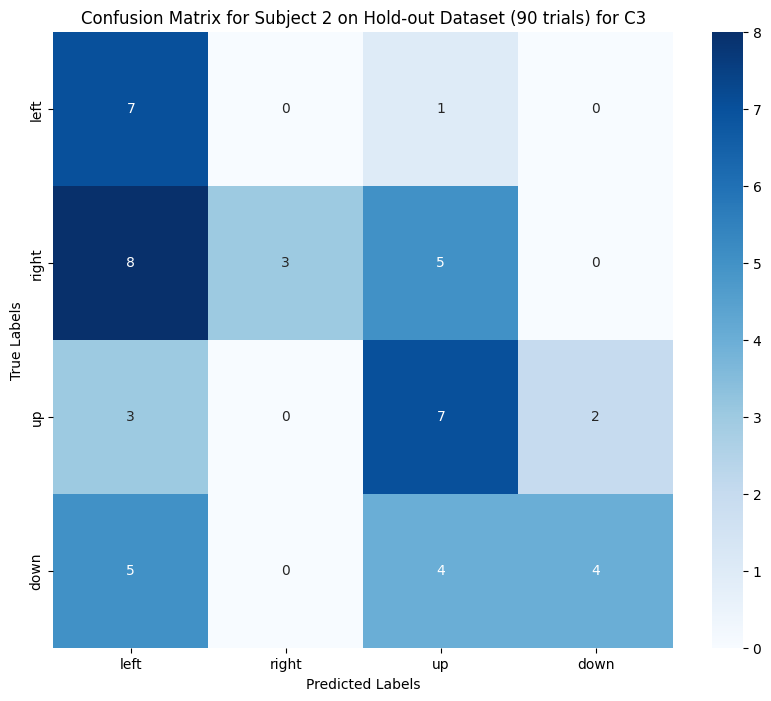

In [43]:
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

for x, y in val_ds:
    y_pred_data_val = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data_val, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)
new_mat = np.zeros((4,4))
# C1
# new_mat[0:2, 0:2] = conf_mat[0:2, 0:2]
# new_mat[0:2, 2:4] = conf_mat[0:2, 2:4]
# new_mat[2:4, 2:4] = conf_mat[4:6, 4:6]
# new_mat[2:4, 0:2] = conf_mat[4:6, 0:2]
# C2
# new_mat[0:4, 0:4] = conf_mat[0:4, 0:4]
# C3
new_mat[0:4, 0:4] = conf_mat[2:6, 2:6]

# conf_mat = multilabel_confusion_matrix(y_true, y_pred) # what?
plt.figure(figsize=(10, 8))
sns.heatmap(new_mat.astype(int), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
# # plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['front', 'back', 'up', 'down']) # C1
# plt.xticks([0.5, 1.5, 2.5, 3.5], ['front', 'back', 'left', 'right']) # C2
plt.xticks([0.5, 1.5, 2.5, 3.5], ['left', 'right', 'up', 'down']) # C3
plt.ylabel('True Labels')
# # plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
# plt.yticks([0.5, 1.5, 2.5, 3.5], ['front', 'back', 'up', 'down']) # C1
# plt.yticks([0.5, 1.5, 2.5, 3.5], ['front', 'back', 'left', 'right']) # C2
plt.yticks([0.5, 1.5, 2.5, 3.5], ['left', 'right', 'up', 'down']) # C3
plt.title(f'Confusion Matrix for Subject {sub_num} on Hold-out Dataset (90 trials) for C3')
# plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Hold-out Dataset For C3.png')

In [44]:
model.evaluate(val_ds, return_dict=True)

4/4 [==============================] - 1s 251ms/step - loss: 1.7741 - accuracy: 0.5333


{'loss': 1.7740622758865356, 'accuracy': 0.5333333611488342}

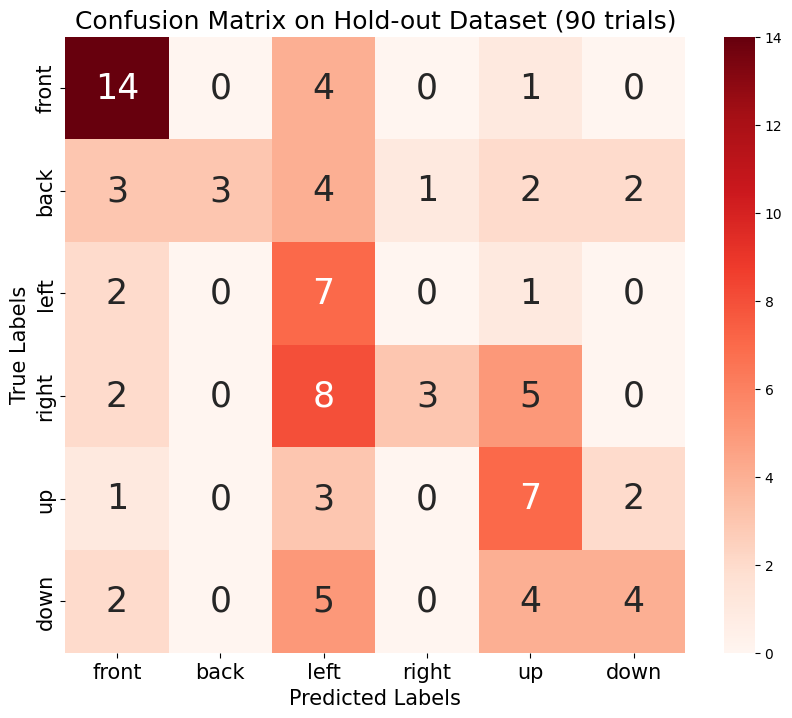

In [55]:
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

for x, y in val_ds:
    y_pred_data_val = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data_val, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)

# conf_mat = multilabel_confusion_matrix(y_true, y_pred) # what?
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds', annot_kws={'size':25})
plt.xlabel('Predicted Labels', fontsize=15)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.ylabel('True Labels', fontsize=15)
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.tick_params(labelsize=15)
plt.title(f'Confusion Matrix for Subject {sub_num} on Hold-out Dataset (90 trials)', fontsize=18)
plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Hold-out Dataset -new.png')

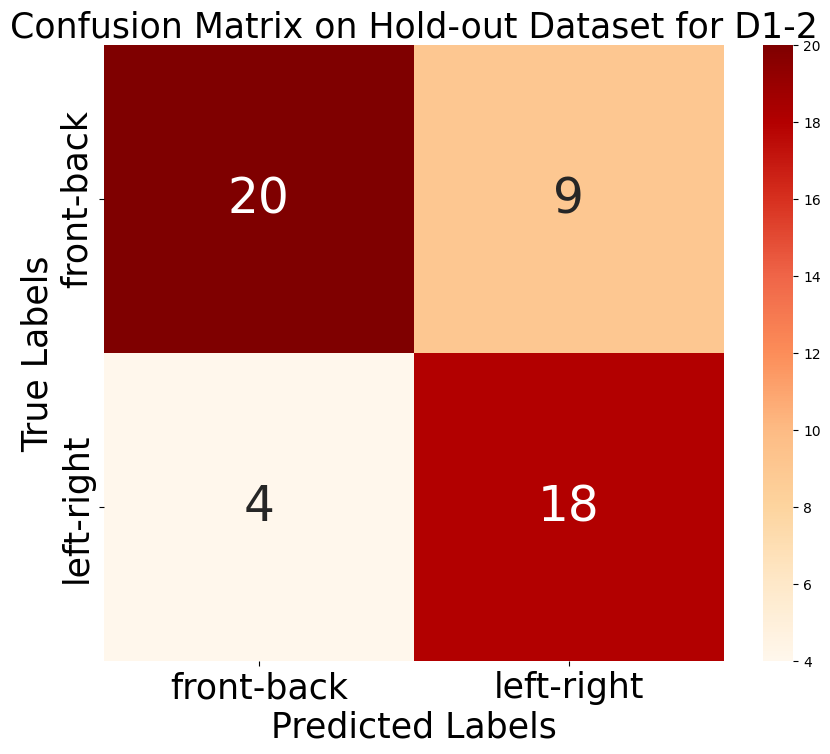

In [61]:
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

for x, y in val_ds:
    y_pred_data_val = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data_val, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)
new_mat = np.zeros((2,2))
# D13
# new_mat[0, 0] = np.sum(conf_mat[0:2, 0:2])
# new_mat[0, 1] = np.sum(conf_mat[0:2, 2:4])
# new_mat[1, 1] = np.sum(conf_mat[4:6, 4:6])
# new_mat[1, 0] = np.sum(conf_mat[4:6, 0:2])
# D12
new_mat[0, 0] = np.sum(conf_mat[0:2, 0:2])
new_mat[0, 1] = np.sum(conf_mat[0:2, 2:4])
new_mat[1, 1] = np.sum(conf_mat[2:4, 2:4])
new_mat[1, 0] = np.sum(conf_mat[2:4, 0:2])
# D23
# new_mat[0, 0] = np.sum(conf_mat[2:4, 2:4])
# new_mat[0, 1] = np.sum(conf_mat[2:4, 4:6])
# new_mat[1, 1] = np.sum(conf_mat[4:6, 4:6])
# new_mat[1, 0] = np.sum(conf_mat[4:6, 2:4])

# conf_mat = multilabel_confusion_matrix(y_true, y_pred) # what?
plt.figure(figsize=(10, 8))
sns.heatmap(new_mat.astype(int), annot=True, fmt='d', cmap='OrRd', annot_kws={'size':35})
plt.xlabel('Predicted Labels', fontsize=25)
# # plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
# plt.xticks([0.5, 1.5], ['front-back', 'up-down']) # D13
plt.xticks([0.5, 1.5], ['front-back', 'left-right']) # D12
# plt.xticks([0.5, 1.5], ['left-right', 'up-down']) # D23
plt.ylabel('True Labels', fontsize=25)
# # plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
# plt.yticks([0.5, 1.5], ['front-back', 'up-down']) # D13
plt.yticks([0.5, 1.5], ['front-back', 'left-right']) # D12
# plt.yticks([0.5, 1.5], ['left-right', 'up-down']) # D23
plt.tick_params(labelsize=25)
plt.title(f'Confusion Matrix on Hold-out Dataset for D1-2', fontsize=25)
plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Hold-out Dataset For D1-2 -ori.png')